**Course Name：** DAT341 / DIT867 Applied Machine Learning

**Examiner：** Richard Johansson (richajo@chalmers.se)

**Assignment No.:** Assignment 2 - Random forests

**Release Date:** Fri, 19 Jan 2024 0:00am

**Due Date:** Tue, 30 Jan 2024 11:59pm

**Group Name:** PA 2 3

**Group Members:**
- Natalia Alvarado (gusalvarsi@student.gu.se)
- Erdem Halil (gushaliler@student.gu.se)
- Xujie Li (guslixuf@student.gu.se)


In [1]:
from google.colab import drive
import sys

drive.mount('/content/drive')

# Adjust the path to point to the folder in my Google Drive
folder_path = '/content/drive/My Drive/DIT867_AML/Assignment_2'
sys.path.append(folder_path)


# **Task 1: Working with a dataset with categorical features**
## **Step 1. Reading the data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time


In [3]:
# Read train and test data
adult_train = pd.read_csv(f'{folder_path}/adult_train.csv')
adult_test = pd.read_csv(f'{folder_path}/adult_test.csv')
# adult_train = pd.read_csv(f'adult_train.csv')
# adult_test = pd.read_csv(f'adult_test.csv')

# Shuffle the train data
adult_train = adult_train.sample(frac=1.0, random_state=0)


# Split train and test data into features and target
Xtrain = adult_train.drop('target', axis=1)
Ytrain = adult_train['target']
Xtest = adult_test.drop('target', axis=1)
Ytest = adult_test['target']


## **Step 2: Encoding the features as numbers.**

In [4]:
from sklearn.feature_extraction import DictVectorizer

# Convert data to dictionary
Xtrain_dict = Xtrain.to_dict('records')
Xtest_dict = Xtest.to_dict('records')

dv = DictVectorizer()

# Fit and transform test and training data with DictVectorizer
Xtrain_encoded = dv.fit_transform(Xtrain_dict)
# NOTE: No need to train the DictVectorizer on the test data
# So we only call transform
Xtest_encoded = dv.transform(Xtest_dict)


## **Step 3. Combining the steps.**

Use `DecisionTreeClassifier` to predict

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier()

# Get the mean cross validation score for the training data on Decision Tree Classifier
cv_train = cross_val_score(dtc, Xtrain_encoded, Ytrain).mean()
cv_train

0.8189246294785217

In [6]:
# Fit the model on the training data
dtc.fit(Xtrain_encoded, Ytrain)

# Evaluate on the test data and print the result
accuracy_test = dtc.score(Xtest_encoded, Ytest)
accuracy_test

0.8186229347091702

Put `DecisionTreeClassifier` into a `Pipeline` to predict

In [7]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    DictVectorizer(),
    DecisionTreeClassifier()
)

cv_train = cross_val_score(pipeline, Xtrain_dict, Ytrain).mean()
cv_train

0.8192317783635147

In [8]:
# Fit the pipeline on the training data
pipeline.fit(Xtrain_dict, Ytrain)

# Get the accuracy on the test data
pipeline.score(Xtest_dict, Ytest)

0.8167802960506111

# **Task 2: Decision trees and random forests**
**Underfitting and overfitting in decision tree classifiers.**

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import time

def plot_acc(train_dict, test_dict, title):
    """Outputs the graph of Accuracy vs Depth from two dictionaries"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_dict.keys(), train_dict.values(), color='red', marker='o', label='Accuracy on train')
    plt.plot(test_dict.keys(), test_dict.values(), color='blue', marker='o', label='Accuracy on test')
    plt.title(title)
    plt.xlabel("Tree Depth")
    plt.ylabel("Accuracy")
    plt.xticks(range(1, 21))
    plt.legend()
    plt.show()

In [10]:
ACC_train = dict()
ACC_test = dict()
tree_depth_range = range(1, 21)

for i in tree_depth_range:
    pipeline = Pipeline([('dv', DictVectorizer()), ('dtc', DecisionTreeClassifier())])
    pipeline.set_params(dtc__max_depth=i)
    pipeline.fit(Xtrain_dict, Ytrain)
    acc_train = accuracy_score(Ytrain, pipeline.predict(Xtrain_dict))
    ACC_train[i] = acc_train
    acc_test = accuracy_score(Ytest, pipeline.predict(Xtest_dict))
    ACC_test[i] = acc_test

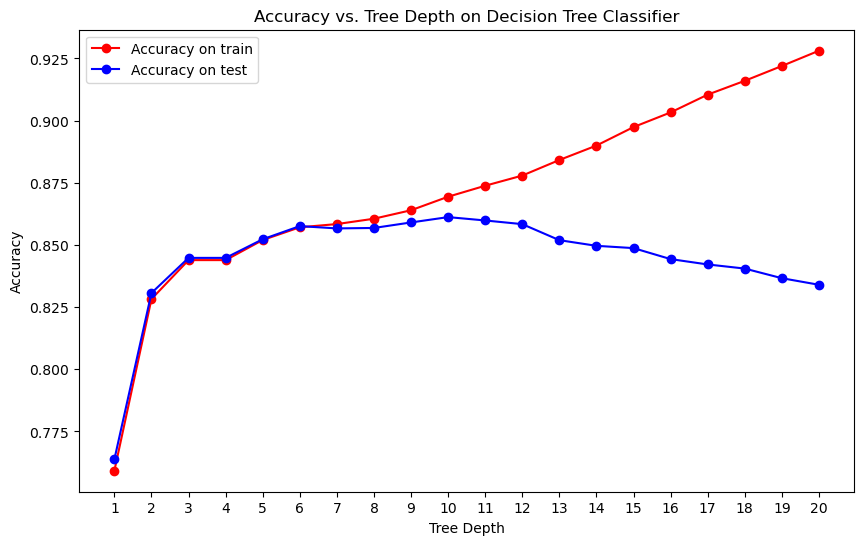

In [11]:
plot_acc(ACC_train, ACC_test, "Accuracy vs. Tree Depth on Decision Tree Classifier")

In [12]:
best_depth = max(ACC_test.items(), key=lambda x: x[1])
print(f"Depth with the highest accuracy score on the test data:\n{best_depth}")

Depth with the highest accuracy score on the test data:
(10, 0.8611878877218844)


While testing with different number of trees with the Decision Tree Classifier, we find a similar effect as with the past assignment. At the first steps, each additional unit for the depth increases the accuracy for both the training and test data. However, the improvement on the test data increases with more tree depth up to a point; in the case of these data, up to around 9 to 10 max. depth, afterwards it only improves on the training data, which is a clear sign of an overfit.

**Underfitting and overfitting in random forest classifiers**

In [13]:
def forestMe(nEnsemble,tree_depth_range):
  ACC_train = dict()
  ACC_test = dict()
  t0 = time.time()
  tt = 0
  for i in tree_depth_range:
      # Set pipeline
      pipeline = Pipeline([('dv', DictVectorizer()), ('rfc', RandomForestClassifier(n_estimators=nEnsemble, n_jobs=-1))])
      pipeline.set_params(rfc__max_depth=i)
      # Fit
      pipeline.fit(Xtrain_dict, Ytrain)
      acc_train = accuracy_score(Ytrain, pipeline.predict(Xtrain_dict))
      ACC_train[i] = acc_train
      if i == 20:
        t1 = time.time()
      # Test
      acc_test = accuracy_score(Ytest, pipeline.predict(Xtest_dict))
      ACC_test[i] = acc_test
  t = t1 - t0
  return ACC_train, ACC_test, t

In [14]:

forestResults = {i: dict(zip(('train', 'test', 'time'), forestMe(i,tree_depth_range))) for i in [1,5,25,50,100,150,200,250]}


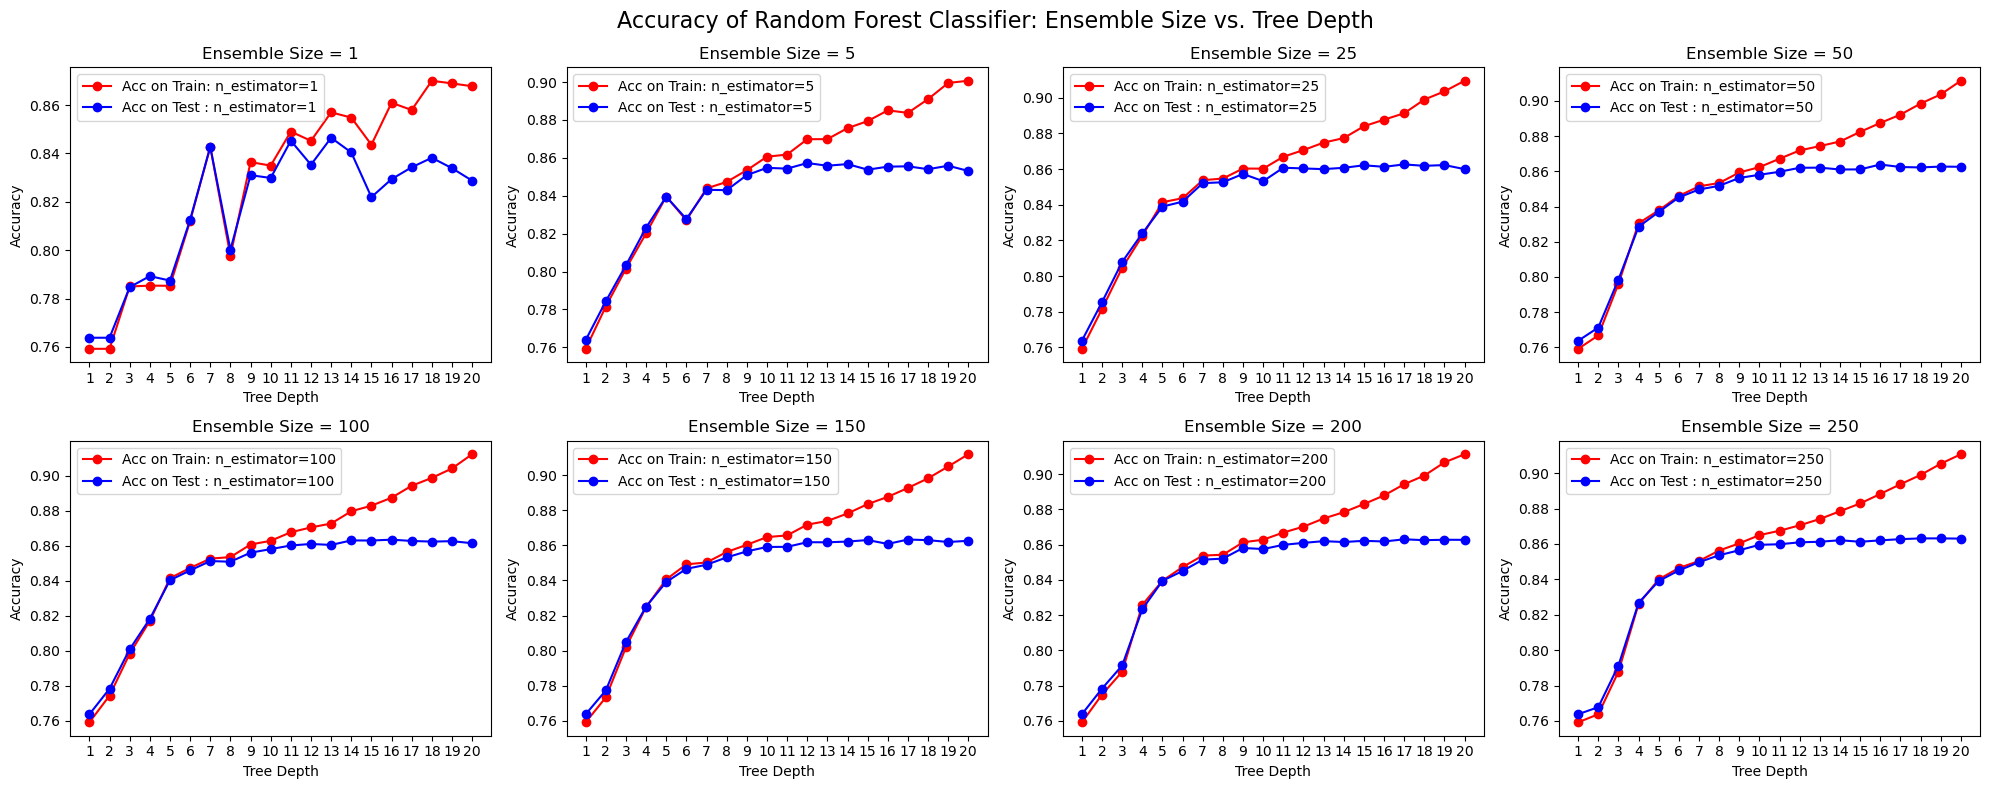

In [15]:
# Creating a figure with 2 rows and 4 columns of subplots
fig, axs = plt.subplots(2, (len(forestResults)+1)//2, figsize=(20,8))
# Flattening the axes array for easy indexing
axs = axs.flatten()

for i, (key, value) in enumerate(forestResults.items()):
    train_label = f"Acc on Train: n_estimator={key}"
    test_label =  f"Acc on Test : n_estimator={key}"
    axs[i].plot(value['train'].keys(), value['train'].values(), color='red', marker='o', label=train_label)
    axs[i].plot(value['test'].keys(), value['test'].values(), color='blue', marker='o', label=test_label)
    axs[i].set_title(f"Ensemble Size = {key}")
    axs[i].set_xlabel("Tree Depth")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_xticks(tree_depth_range)
    axs[i].set_xticklabels(tree_depth_range)
    axs[i].legend()

fig.suptitle('Accuracy of Random Forest Classifier: Ensemble Size vs. Tree Depth', fontsize=16)
plt.tight_layout()
plt.show();


**What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?**


For a single decision tree and a random forest with an ensemble size of 1, when the depth of the tree depth increases, the discrepancy between the accuracy on the training set and the test set continues to widen, indicating overfitting. However, their curves are not identical.

The difference in the accuracy curves is that for a single decision tree, the curve is relatively smooth, while for a random forest with an ensemble size of 1, there are more noticeable fluctuations. This is due to the random forest's method of randomly selecting features and samples to form each individual decision tree.

Random Forest classification is based on creating 'n' trees from random subsets of the data and determining the classification outcome through a majority vote. Instead of depending on a single tree, it utilizes multiple trees as specified in the parameter, resulting in a more robust decision-making process.

Since Random Forest begins each tree with a random subset of data, accuracy does not necessarily improve with each increase in maximum depth, a principle that applies even to the training data from which it is derived. This contrasts with a tree classifier that uses all available data, which is more likely to overfit to the training data.

**What happens with the curve for random forests as the ensemble size grows?**

As the number of estimator to make a decision grows, the line of accuracy vs ensemble size becomes smoother. This indicates that the more trees used to make a decision, the more reliable the decision will become. In addition, it means that the impact of a single tree on the final decision decreases, making the model's prediction results more robust and reducing accuracy fluctuations caused by abnormal predictions of some specific trees.

In general, as the ensemble size grows, the accuracy on the training set is still rising, while the accuracy on the test set tends to level off and reaches a bottleneck, and the overfitting of the model gradually intensifies.

**What happens with the best observed test set accuracy as the ensemble size grows?**

As the ensemble size grows, particularly when the number of trees increases to a certain level, the accuracy improvement of the model on test set may become very small, or even reach a bottleneck. This is because the model may have reached a "ceiling" on the amount of information a given data set can provide. Although random forest improves the generalization ability of the model by introducing randomness in the construction process of each tree, as the number of trees increases, the gain of the model will gradually decrease due to the repetition of randomly selected features and samples.

**What happens with the training time as the ensemble size grows?**

As the ensemble size increases, as illustrated in the graph below, the training time correspondingly grows.

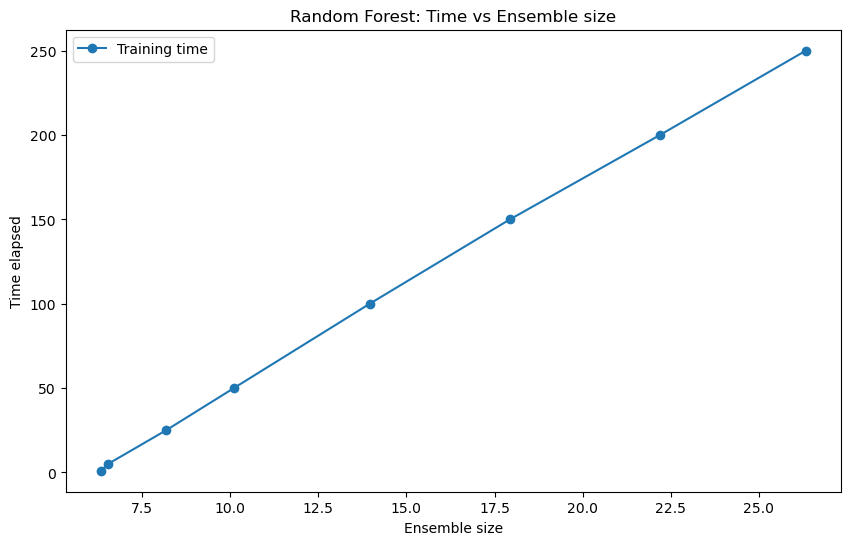

In [16]:
# Start plot
plt.figure(figsize=(10, 6))
plt.plot([forestResults[e]['time'] for e in forestResults.keys()], forestResults.keys(), marker='o', label='Training time')
plt.title("Random Forest: Time vs Ensemble size")
plt.xlabel("Ensemble size")
plt.ylabel("Time elapsed")
plt.legend()
plt.show()


# **Task 3: Feature importances in random forest classifiers**

**Compute feature importances with decision tree classifer**

In [17]:
# Create a pipeline with preprocessor and a decision tree classifier
dt_pipeline = Pipeline(steps=[
    ('vectorizer', DictVectorizer()),
    ('classifier', DecisionTreeClassifier())
])

# train the pipeline
dt_pipeline.fit(Xtrain_dict, Ytrain)

# get the decision tree classier
clf = dt_pipeline.named_steps['classifier']

# get feature importances
feature_importances = clf.feature_importances_

# For categorical features, get the feature name converted by DictVectorizer
transformed_features = (dt_pipeline.named_steps['vectorizer']
                        .get_feature_names_out())

# create a DataFrame showing feature names and their importance
feature_importance_df = pd.DataFrame({'Feature': transformed_features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# display the top 10 most important features
feature_importance_df.head(10)



,Feature,Importance
23,marital-status=Married-civ-spouse,0.214150
0,age,0.161747
3,education-num,0.123125
1,capital-gain,0.119059
20,hours-per-week,0.101645
2,capital-loss,0.043959
102,workclass=Private,0.014584
104,workclass=Self-emp-not-inc,0.010366
74,occupation=Exec-managerial,0.010137
80,occupation=Prof-specialty,0.009449


**Compute feature importances with random forest classifer**

In [18]:
# Create a pipeline with preprocessor and a decision tree classifier
rf_pipeline = Pipeline(steps=[
    ('vectorizer', DictVectorizer()),
    ('classifier', RandomForestClassifier(n_jobs=-1))
])

# train the pipeline
rf_pipeline.fit(Xtrain_dict, Ytrain)

# get the decision tree classier
clf = rf_pipeline.named_steps['classifier']

# get feature importances
feature_importances = clf.feature_importances_

# For categorical features, get the feature name converted by DictVectorizer
transformed_features = (rf_pipeline.named_steps['vectorizer']
                        .get_feature_names_out())

# create a DataFrame showing feature names and their importance
feature_importance_df = pd.DataFrame({'Feature': transformed_features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# display the top 10 most important features
feature_importance_df.head(10)



,Feature,Importance
0,age,0.226101
20,hours-per-week,0.113807
1,capital-gain,0.110979
23,marital-status=Married-civ-spouse,0.069613
3,education-num,0.064596
90,relationship=Husband,0.044687
2,capital-loss,0.034727
25,marital-status=Never-married,0.022427
74,occupation=Exec-managerial,0.018525
80,occupation=Prof-specialty,0.015760


**Feature importance based on random forest is biased.**

Feature importance in decision trees or random forests is all about the mean decrease in impurity (or gini importance). It measures how well a feature reduces impurity or variance when we're building the trees in the random forests.

However, this standard method for calculating feature importance in random forests has a bias. It tends to overstate the importance of features that are continuous or have a lot of different categories.

**An alternative way to compute feature importance using permutation importance.**

To correct this bias, a more effective method is permutation importance. This approach works by first establishing a baseline performance, using either accuracy (for classifiers) or R2 score (for regressors), which is obtained by running a validation set or out-of-bag (OOB) samples through the Random Forest. Then, we shuffle the values in one feature's column and rerun the altered data through the Random Forest, recalculating the performance metric. The significance of the feature is determined by how much the performance—accuracy or R2—decreases compared to the baseline when we mix up the feature's data.


refered to [Breiman and Cutler](https://explained.ai/rf-importance/)

**Advantages and disadvantages of permutation importance.**

The strategy of permutation importance eliminates the need to retrain the model each time a feature's values are shuffled. To assess the impact of this shuffling on the model's overall accuracy, all that is needed is to pass the test samples, with their features rearranged, through the model that has already been trained.

While this permutation method takes more computing power than calculating mean decrease in impurity, it gives us a more trustworthy measure of feature importance.

refered to [Breiman and Cutler](https://explained.ai/rf-importance/)

In [19]:
from rfpimp import permutation_importances
from sklearn.metrics import accuracy_score

def accuracy(rf, X, y):
    return accuracy_score(y, rf.predict(X))

# Get feature names from DictVectorizer
feature_names = dv.feature_names_

# Create a DataFrame from the dense matrix with correct feature names
Xtrain_encoded_df = pd.DataFrame(Xtrain_encoded.toarray(), columns=feature_names)

# train a random forest forest classifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(Xtrain_encoded_df, Ytrain)

# Compute importances
importances = permutation_importances(rf, Xtrain_encoded_df, Ytrain, accuracy)

# Create a DataFrame with feature names and their importances
importances_df = pd.DataFrame(importances, index=feature_names, columns=['Importance']) \
                .reset_index(drop=False).rename(columns={'index':'Feature'})

# Sort the DataFrame by importance and take the top 10
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(10)
importances_df




,Feature,Importance
0,age,0.1022
20,hours-per-week,0.0732
90,relationship=Husband,0.0466
1,capital-gain,0.0410
3,education-num,0.0336
25,marital-status=Never-married,0.0290
74,occupation=Exec-managerial,0.0270
102,workclass=Private,0.0222
80,occupation=Prof-specialty,0.0216
15,education=HS-grad,0.0214
